# WallStreetBets Sentiment Analysis
## Capstone Project
---
- Name: Kai Cansler
- Student Pace: Flex
- Instructor: Mark Barbour

### Overview
In the fast paced growth of easy access to individual brokerage accounts the number of retail traders have grown immensely in the stock market. Retail traders now find communities online to share ideas on new stock picks. We want to understand how retail trader sentiment on popular networks effect stock prices. I will look at WallStreetBets specifically to understand sentiment and whether the stock price went up or down.

### Business Understanding


### Data Understanding
I am to using Reddit wallstreetbets posts dataset from [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts) along with stock data from [IEX](https://www.iexexchange.io/products/market-data-connectivity) or [AlphaVantage](https://www.alphavantage.co). The target variable will be whether the stock price increases or decreases.

WallStreetBets Data:

## Libraries and Tools

In [1]:
#!pip install plotly -q 

In [2]:
#!pip install nltk -q

In [3]:
#!pip install spacy -q

In [4]:
#!pip install statsmodels -q

In [5]:
!pip install pandas -q

In [6]:
# Base
import numpy as np # Lin Algebra
import pandas as pd # Data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
plt.rc('figure',figsize=(16,12))

# Sentiment Analysis
import re
import string
import nltk

# Natural Language Modeling
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import Isomap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from nltk import word_tokenize
import spacy as sp
nlps = sp.load('en_core_web_sm')
import random

# Standard Modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR, AutoReg

import warnings
# Ignore that annoying Deprecation Warning
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kaicansler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
wsb_data = pd.read_csv('data/reddit_wsb.csv')
wsb_data = wsb_data[pd.to_datetime(wsb_data.timestamp).dt.year>=2021]
wsb_data.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  
0                                                NaN  2021-01-28 21:37:41  
1                                                NaN  2021-01-28 21:32:10  
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35  
3                                                NaN  2021-01-28 21:28:57  
4                                                NaN  2021-01-28 21:26:56

## Preprocessing
We want to make our text data more accessible for our EDA and modeling.

In [8]:
# Load separately title and body and remove "NA" values
title_data = wsb_data[['title', 'timestamp']].copy()
body_data = wsb_data[['body', 'timestamp']].copy()
title_data = title_data.dropna()
body_data = body_data.dropna()

# Make the string all lower for processing
title_data.title = title_data.title.str.lower()
body_data.body = body_data.body.str.lower()

# Make date without time
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
title_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

# Remove Handle info
title_data.title = title_data.title.apply(lambda x: re.sub('@[^\s]+', '', x))
title_data.body = body_data.body.apply(lambda x: re.sub('@[^\s]+', '', x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x: re.sub(r'http\S+', '', x))
body_data.body = body_data.body.apply(lambda x: re.sub(r'http\S+', '', x))

# Remove special characters after handle info
title_data.title = title_data.title.apply(lambda x: ' '.join(re.findall(r'\w+', x)))
body_data.body = body_data.body.apply(lambda x: ' '.join(re.findall(r'\w+', x)))

# Remove all single characters
title_data.title = title_data.title.apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body = body_data.body.apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Fix double spaces in data
title_data.title = title_data.title.apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body = body_data.body.apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))

/var/folders/0m/xw3yjm2x31z33qvwd43sz67c0000gp/T/ipykernel_32680/1569199698.py:17: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



## Feature Engineering
Now that are text data is more accessible to our tools we will now engineer our features to model them more effectlively.

In [9]:
# Adding wsb/reddit flavor to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'citron': -4.0,  
    'hidenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
    'tendies': 2.0,
    'town': 2.0,     
    'overvalued': -3.0,
    'undervalued': 3.0,
    'buy': 4.0,
    'sell': -4.0,
    'gone': -1.0,
    'gtfo': -1.7,
    'paper': -1.7,
    'bullish': 3.5,
    'bearish': -3.5,
    'bagholder': -1.7,
    'stonk': 1.9,
    'green': 1.9,
    'money': 1.2,
    'print': 2.2,
    'rocket': 2.2,
    'bull': 2.9,
    'bear': -2.9,
    'pumping': -1.0,
    'sus': -3.0,
    'offering': -2.3,
    'rip': -4.0,
    'downgrade': -3.0,
    'upgrade': 3.0,     
    'maintain': 1.0,          
    'pump': 1.9,
    'hot': 1.5,
    'drop': -2.5,
    'rebound': 1.5,  
    'crack': 2.5,
}

sia = SentimentIntensityAnalyzer()
nltk.download('vader_lexicon')
sia.lexicon.update(new_words)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kaicansler/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# Collect sentiment and organize into Positive, Neutral, and Negative for title data
title_data['sentiments'] = title_data['title'].apply(lambda x: sia.polarity_scores(' '.join(re.findall(r'\w+', x.lower()))))
title_data['Positive Sentiment'] = title_data['sentiments'].apply(lambda x: x['pos'])#+1*(10**-6)
title_data['Neutral Sentiment'] = title_data['sentiments'].apply(lambda x: x['neu'])
title_data['Negative Sentiment'] = title_data['sentiments'].apply(lambda x: x['neg'])

In [11]:
# Collect sentiment and organize into Positive, Neutral, and Negative for body data
body_data['sentiments'] = body_data['body'].apply(lambda x: sia.polarity_scores(' '.join(re.findall('r\w+', x.lower()))))
body_data['Positive Sentiment'] = body_data['sentiments'].apply(lambda x: x['pos'])#+1*(10**-6)
body_data['Neutral Sentiment'] = body_data['sentiments'].apply(lambda x: x['neu'])
body_data['Negative Sentiment'] = body_data['sentiments'].apply(lambda x: x['neg'])

In [12]:
# Drop sentiments column for cleanliness
title_data.drop(columns=['sentiments'], inplace=True)
body_data.drop(columns=['sentiments'], inplace=True)

### Feature Creation
We want to understand more about our title and body and store this information in new columns for ease of access.

In [13]:
# Update stop words
stopwords = set(STOPWORDS)
stopwords.update(['t', 'co', 'https', 'amp', 'U', 'fuck', 'fucking', 'porn', ])

# Extract number of words from body
body_data['Num Words'] = body_data['body'].apply(lambda x: len(x.split(' ')))
# Extract number of stopwords from body
body_data['Num Stopwords'] = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
# Extract avg length of a word that's not a stopword from body
body_data['Avg Word Length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(word) for word in x.split(' ') if word not in list(STOPWORDS)])))

/Users/kaicansler/miniforge3/envs/learn-env-tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/Users/kaicansler/miniforge3/envs/learn-env-tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [14]:
# Extract number of words from body
title_data['Num Words'] = title_data['title'].apply(lambda x: len(x.split(' ')))
# Extract number of stopwords from body
title_data['Num Stopwords'] = title_data['title'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
# Extract avg length of a word that's not a stopword from title
title_data['Avg Word Len'] = title_data['title'].apply(lambda x: np.mean(np.array([len(word) for word in x.split(' ') if word not in list(STOPWORDS)])))

/Users/kaicansler/miniforge3/envs/learn-env-tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/Users/kaicansler/miniforge3/envs/learn-env-tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



## Finding Entity Mentions
Now we want to know how many times a entity is mentioned to measure the sentiment for that specific entity. Our end goal is to determine if WSB sentiment can be an indicator to market movement.

In [15]:
# Count Number of times an Organization is mentioned in text (May Take some Time)
title_data['Organizations Mentioned'] = title_data['title'].apply(lambda x: len([ent for ent in nlps(x).ents if ent.label_ == 'ORG']))
body_data['Organizations Mentioned'] = body_data['body'].apply(lambda x: len([ent for ent in nlps(x).ents if ent.label_ == 'ORG']))
print(title_data.head(3))
print(body_data.head(3))

                                               title   timestamp  \
0       itnot about the money itabout sendingmessage         NaN   
1  math professor scott steiner says the numbers ...         NaN   
2                                    exit the system  2021-01-28   

   Positive Sentiment  Neutral Sentiment  Negative Sentiment  Num Words  \
0               0.306              0.694               0.000          6   
1               0.000              0.728               0.272         12   
2               0.000              1.000               0.000          3   

   Num Stopwords  Avg Word Len  Organizations Mentioned  
0              2          7.75                        0  
1              2          6.30                        0  
2              1          5.00                        0  
                                                body            timestamp  \
2  the ceo of nasdaq pushed to halt trading to gi...  2021-01-28 21:30:35   
6  hedgefund whales are spreading disinf

## Distribution of Sentiment Data
Now lets look at the distribution of our sentiment in the title and body.

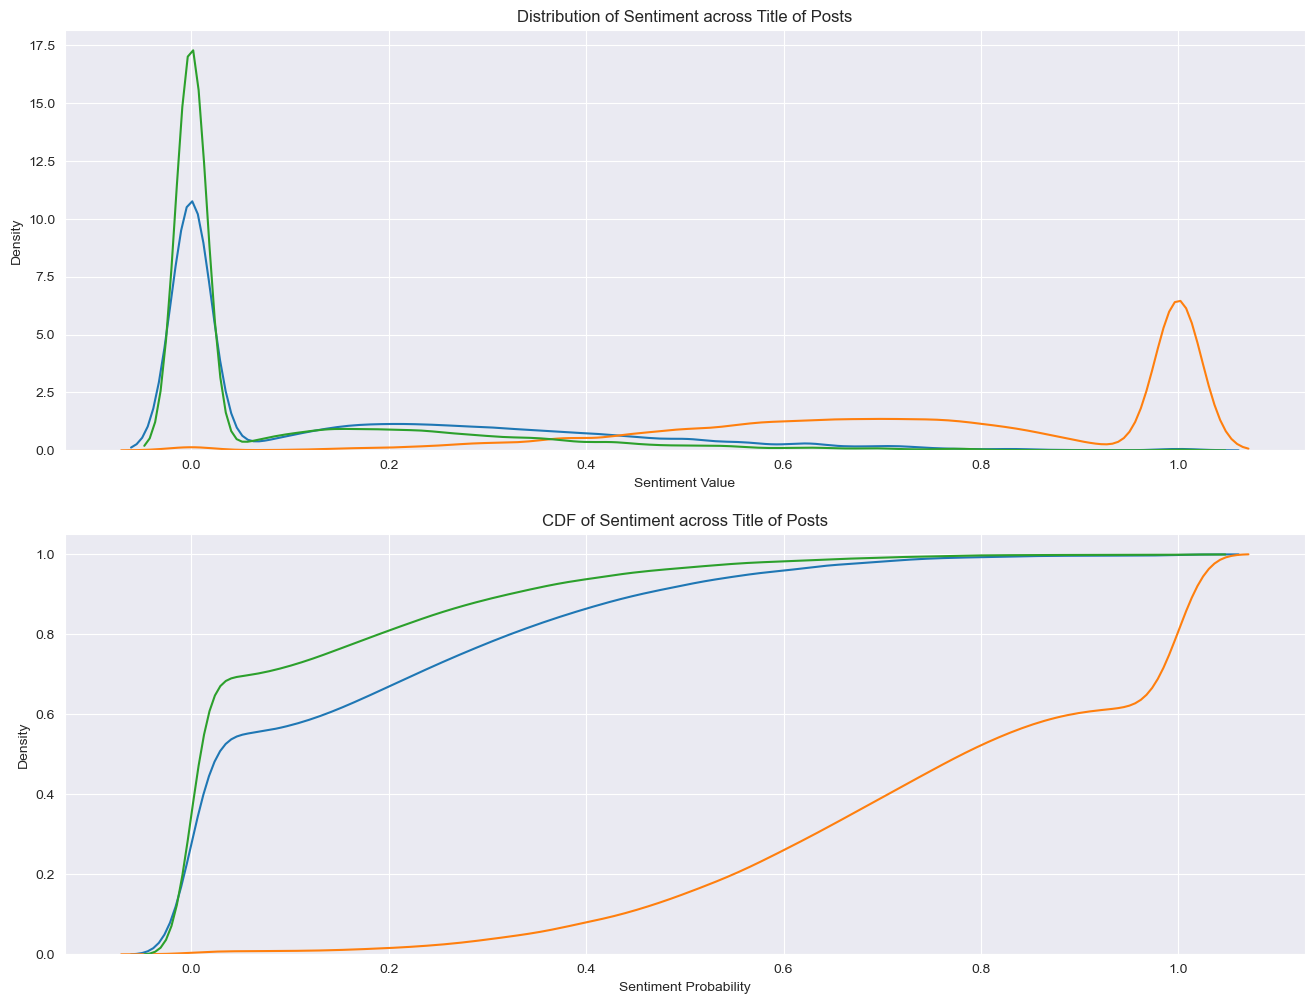

In [16]:
plt.subplot(2,1,1)
sns.kdeplot(title_data['Positive Sentiment'], bw_method=0.1)
sns.kdeplot(title_data['Neutral Sentiment'], bw_method=0.1)
sns.kdeplot(title_data['Negative Sentiment'], bw_method=0.1)
plt.title('Distribution of Sentiment across Title of Posts')
plt.xlabel('Sentiment Value')

plt.subplot(2,1,2)
sns.kdeplot(title_data['Positive Sentiment'], bw_method=0.1, cumulative=True)
sns.kdeplot(title_data['Neutral Sentiment'], bw_method=0.1, cumulative=True)
sns.kdeplot(title_data['Negative Sentiment'], bw_method=0.1, cumulative=True)
plt.title('CDF of Sentiment across Title of Posts')
plt.xlabel('Sentiment Probability')
plt.show()

***Interpretation:***
Looking at the distribution a majority of the post titles show a neutral sentiment. The Negative and Positive sentiment are mostly 0 with weak values of sentiment. There is a 65% or greater probability that the title is classified as neutral.

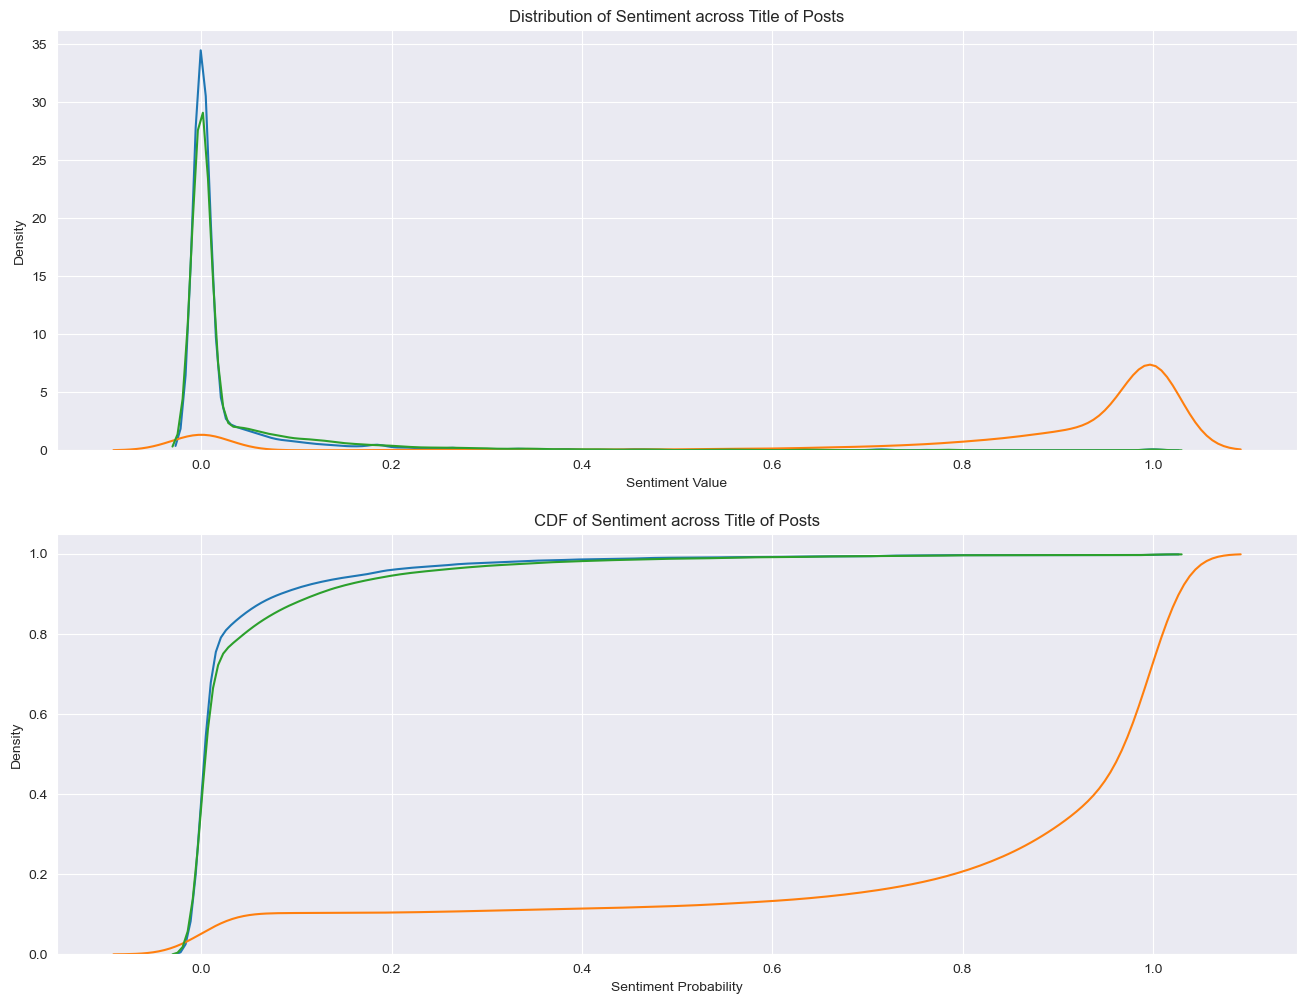

In [17]:
plt.subplot(2,1,1)
sns.kdeplot(body_data['Positive Sentiment'], bw_method=0.1)
sns.kdeplot(body_data['Neutral Sentiment'], bw_method=0.1)
sns.kdeplot(body_data['Negative Sentiment'], bw_method=0.1)
plt.title('Distribution of Sentiment across Title of Posts')
plt.xlabel('Sentiment Value')

plt.subplot(2,1,2)
sns.kdeplot(body_data['Positive Sentiment'], bw_method=0.1, cumulative=True)
sns.kdeplot(body_data['Neutral Sentiment'], bw_method=0.1, cumulative=True)
sns.kdeplot(body_data['Negative Sentiment'], bw_method=0.1, cumulative=True)
plt.title('CDF of Sentiment across Title of Posts')
plt.xlabel('Sentiment Probability')
plt.show()

## Understanding Common Words by Sentiment

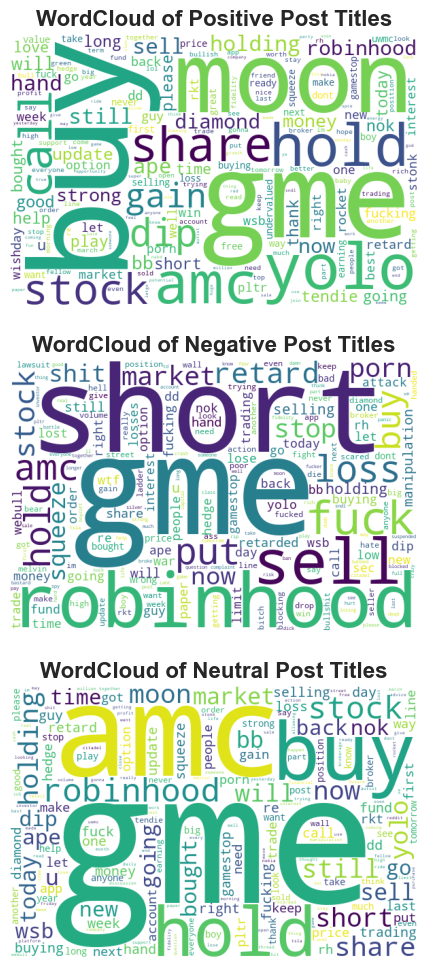

In [18]:
common_positive = title_data[title_data['Positive Sentiment'].between(0.25,1)]['title']
common_negative = title_data[title_data['Negative Sentiment'].between(0.25,1)]['title']
common_neutral = title_data[title_data['Neutral Sentiment'].between(0.25,1)]['title']

common_positive_str = ' '.join(common_positive)
common_negative_str = ' '.join(common_negative)
common_neutral_str = ' '.join(common_neutral)

pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(common_positive_str)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(common_negative_str)
nuwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(common_neutral_str)

plt.subplot(3,1,1)
plt.title('WordCloud of Positive Post Titles',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(3,1,2)
plt.title('WordCloud of Negative Post Titles',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')
plt.subplot(3,1,3)
plt.title('WordCloud of Neutral Post Titles', fontsize=16, fontweight='bold')
plt.imshow(nuwc)
plt.axis('off')
plt.show()

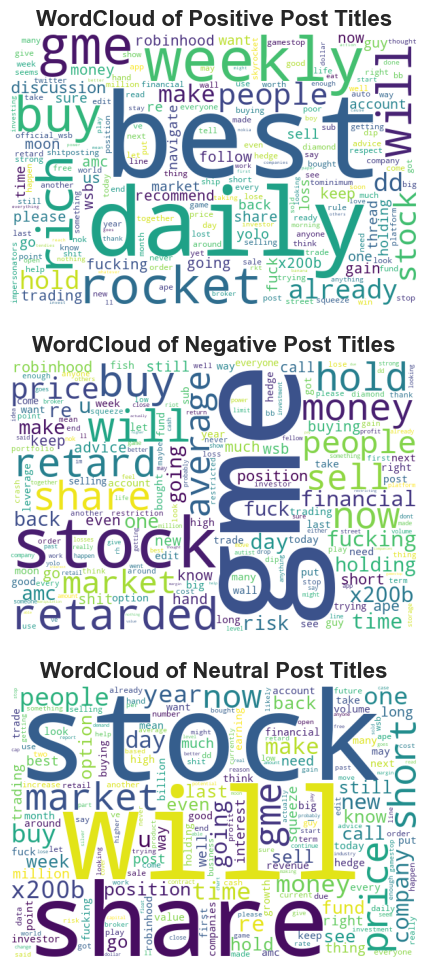

In [19]:
common_positive = body_data[body_data['Positive Sentiment'].between(0.25,1)]['body']
common_negative = body_data[body_data['Negative Sentiment'].between(0.25,1)]['body']
common_neutral = body_data[body_data['Neutral Sentiment'].between(0.25,1)]['body']

common_positive_str = ' '.join(common_positive)
common_negative_str = ' '.join(common_negative)
common_neutral_str = ' '.join(common_neutral)

pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(common_positive_str)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(common_negative_str)
nuwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(common_neutral_str)

plt.subplot(3,1,1)
plt.title('WordCloud of Positive Post Titles',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(3,1,2)
plt.title('WordCloud of Negative Post Titles',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')
plt.subplot(3,1,3)
plt.title('WordCloud of Neutral Post Titles', fontsize=16, fontweight='bold')
plt.imshow(nuwc)
plt.axis('off')
plt.show()

In [20]:
org_mentioned = body_data[body_data['Organizations Mentioned']>0].copy()
org_names = []
for body in org_mentioned.body:
    org_names+=[str(word) for word in nlps(body).ents if word.label_ == 'ORG' ]
        

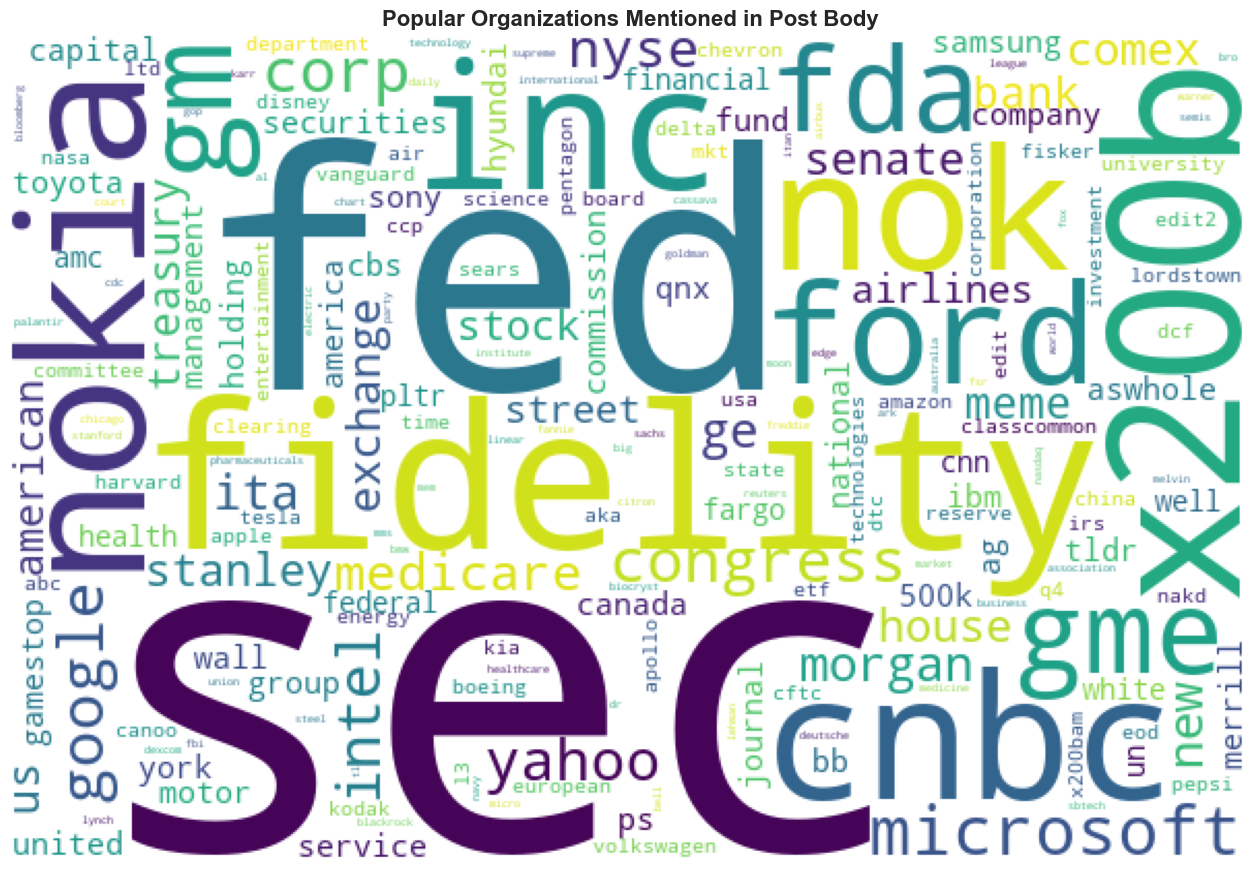

In [21]:
owc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(' '.join(org_names))

plt.title('Popular Organizations Mentioned in Post Body',fontsize=16,fontweight='bold')
plt.imshow(owc)
plt.axis('off')

plt.show()    

# Examine Most Mentioned Organizations

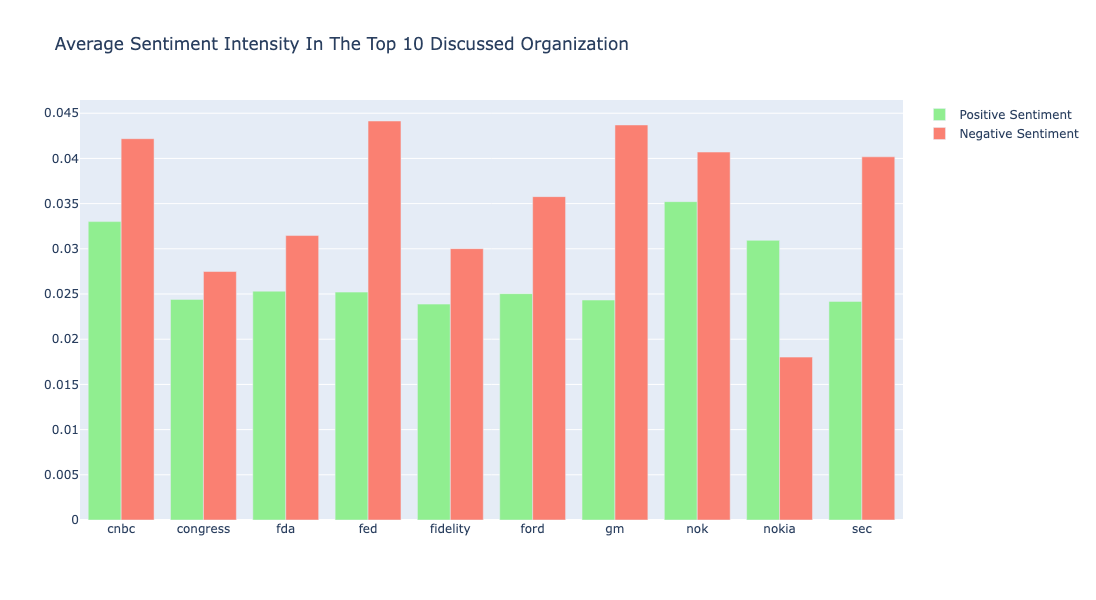

In [22]:
org_freq=dict(nltk.FreqDist(org_names))
org_freq = {k: v for k, v in sorted(org_freq.items(), key=lambda item: item[1],reverse=True)}
top_10_org = list(org_freq.keys())[:10]
mask = []
indx = []
for idx,b in enumerate(org_mentioned.body):
    for m in top_10_org:
        if b.find(m) !=-1:
            mask.append(m)
            indx.append(idx)
            break

top_10_org_df = org_mentioned.iloc[indx,:].copy()
top_10_org_df['Organization'] = mask
top_10_org_df = top_10_org_df.drop(columns=['body', 'timestamp'])

by_org = top_10_org_df.groupby('Organization').mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(x=by_org['Organization'],y=by_org['Positive Sentiment'],name='Positive Sentiment',marker_color='lightgreen'))
fig.add_trace(go.Bar(x=by_org['Organization'],y=by_org['Negative Sentiment'],name='Negative Sentiment',marker_color='salmon'))
fig.update_layout(height=600, width=1000, barmode='group',title='Average Sentiment Intensity In The Top 10 Discussed Organization')

# Stock Movement Prediction with Stock Sentiment
Now we want to identify stocks with most sentiment scores and use those scores to drive predictions.
We will:
1. Identify top 10 stocks.
2. Use top 10 stocks to create new dataframe with sentiment and stock data.
3. Use AlphaVantage to get timeseries price data.
4. Prediction Modeling.

## Find Target Stocks
Obtain Stock Ticker list from nasdaq to identify ticker mentions in WSB posts. We pulled the ticker list from nasdaq:
https://www.nasdaq.com/market-activity/stocks/screener?exchange=nasdaq&letter=0&render=download 

In [23]:
stocks = pd.read_csv('./data/tickers.csv')

# Convert Last Sale to a Float type.
stocks['Last Sale'] = stocks['Last Sale'].str.replace('$', '')
stocks['Last Sale'] = pd.to_numeric(stocks['Last Sale'], downcast='float')
type(stocks['Last Sale'][0])

# Filter out stocks >$3 and > $100 million cap
price_filter = stocks['Last Sale'] >= 3.00
cap_filter = stocks['Market Cap'] >= 100000000

# make set of symbols
stocks = set(stocks[(price_filter) & (cap_filter)]['Symbol'])

blacklist = {
    'I', 'WSB', 'THE', 'A', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR', 'BE', 'IMO', 'ALL', 'RH',
    'EV', 'TOS', 'CFO', 'CTO', 'OK', 'KYS', 'FD', 'US', 'USA', 'IT', 'RIP', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PRAY',
    'FOMO', 'EDIT', 'IPO', 'BUT','USD', 'ON', 'GO', 'MOVE', 'CAN', 'NEXT', 'ME', 'REAL', 'LIFE', 'PLAY', 'EVER', 'STEP', 'ECHO',
    'RIDE', 'RARE', 'GOOD', 'ROAD', 'HAS', 'COOL', 'LOVE', 'ACT', 'ANY', 'HOPE', 'FORM', 'FUND', 'FREE', 'VERY', 'GAIN', 'CASH',
    'HEAR', 'CARE', 'EYE', 'FIVE', 'TEAM', 'LAND', 'TRUE', 'TELL', 'RUN', 'FAT', 'JOBS', 'TECH', 'TALK', 'MF', 'KIDS', 'FATE', 'PLUS',
    'POOL', 'ROCK', 'LOOP', 'YELL', 'BAND', 'TRIP', 'HOOK', 'UNIT', 'VIEW', 'GLAD', 'CENT', 'LAZY', 'EH', 'TOWN', 'RAIN', 'CAR', 'PLUG',
    'WISH', 'FAST', 'JACK', 'HOOD', 'COIN', 'LAWS', 'ERIC', 'CALM', 'TACO', 'PUCK', 'BRAG', 'SWAG', 'WRAP', 'JAN', 'FEB', 'MAR', 'APR',
    'MAY', 'JUN', 'SEPT', 'OCT', 'NOV', 'DEC', 'NICE', 'COST', 'ROLL', 'FOLD', 'APP', 'MASS', 'FOX', 'API', 'RELY', 'APPS', 'SIRI', 'SLAM',
    'ROOT'
}


In [24]:
body_df = pd.DataFrame(body_data)
title_df = pd.DataFrame(title_data)

picks = 5     # define # of picks we want
posts, count, tickers, a_titles, a_bodies = 0, 0, {}, {}, {}

for index, row in body_df.iterrows():
    split = row.body.split(' ') #body_data['body'].apply(lambda x: x.split(' '))
    for word in split:
        word = word.replace("$", "")
        word = word.upper()
        # upper = ticker, length of ticker <= 5, excluded words
        if len(word) <= 5 and word not in blacklist and word in stocks:
                                    
            # counting tickers
            if word in tickers:
                tickers[word] += 1
                a_bodies[word].append(row.body)
                count += 1
            else:
                tickers[word] = 1
                a_bodies[word] = [row.body]
                count += 1

{'TSLA': 709, 'BLUE': 280, 'VIA': 478, 'AXDX': 2, 'BBBY': 146, 'FIZZ': 21, 'PYPL': 26, 'JD': 42, 'NFLX': 51, 'PRPL': 115, 'IRBT': 19, 'AMD': 625, 'SRNE': 7, 'AAL': 133, 'NNDM': 66, 'PAAS': 6, 'ALT': 38, 'CLVS': 5, 'KOSS': 56, 'ATOS': 4, 'NKLA': 58, 'INO': 87, 'ALOT': 123, 'OB': 1, 'GLEE': 4, 'COKE': 42, 'FOSL': 4, 'WW': 19, 'NMIH': 1, 'SOFI': 114, 'SWIM': 28, 'EAR': 37, 'LBC': 1, 'MRNA': 153, 'WB': 11, 'AMCX': 20, 'ISO': 16, 'SOLO': 11, 'SKIN': 111, 'PETS': 32, 'MNKD': 5, 'AAPL': 203, 'MSFT': 99, 'RCEL': 1, 'AGEN': 1, 'WIRE': 51, 'CUE': 12, 'TIL': 79, 'ZION': 3, 'SHEN': 6, 'GP': 7, 'TREE': 84, 'OPK': 13, 'TRIL': 2, 'CD': 29, 'ISLE': 5, 'BASE': 421, 'SP': 125, 'LGND': 18, 'BOOM': 250, 'WBA': 7, 'ACB': 47, 'III': 95, 'THRM': 1, 'TIGR': 35, 'LMAO': 94, 'IMMR': 1, 'RICO': 8, 'RAM': 12, 'TASK': 35, 'IIN': 20, 'LI': 66, 'HA': 34, 'ESQ': 3, 'MTRX': 1, 'BOLT': 18, 'SFT': 1, 'NCTY': 1, 'CAKE': 47, 'CAMP': 21, 'ASO': 268, 'ALTO': 11, 'FB': 112, 'WOOF': 28, 'FORA': 1, 'DISH': 34, 'NIU': 5, 'LEGO'

In [25]:
# sorts the dictionary
symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
top_picks = list(symbols.keys())[0:picks]

print(f"\n{picks} most mentioned picks: ")
times = []
top = []
for i in top_picks:
    print(f"{i}: {symbols[i]}")
    times.append(symbols[i])
    top.append(f"{i}: {symbols[i]}")


10 most mentioned picks: 
AMZN: 753
TSLA: 709
AMD: 625
VIA: 478
BASE: 421
TLRY: 374
CLOV: 307
BLUE: 280
ASO: 268
VIAC: 264


In [26]:
scores, s = {}, {}

vader = SentimentIntensityAnalyzer()
# adding custom words from data.py
vader.lexicon.update(new_words)

picks_sentiment = list(symbols.keys())[0: picks]
for symbol in picks_sentiment:
    stock_bodies = a_bodies[symbol]
    for body in stock_bodies:
        score = vader.polarity_scores(body)
        if symbol in s:
            s[symbol][body] = score
        else:
            s[symbol] = {body: score}
        if symbol in scores:
            for key, _ in score.items():
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score

    # calculating averages
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols[symbol]
        scores[symbol][key] = "{pol:.3f}".format(pol=scores[symbol][key])


In [27]:
# Printing sentiment analysis
print(f"\nSentiment analysis of top {picks} picks:")
df = pd.DataFrame(scores)
df.index = ['Negative', 'Neutral', 'Positive', 'Total_Compound']
df = df.T
print(df)



Sentiment analysis of top 10 picks:
     Negative Neutral Positive Total_Compound
AMZN    0.011   0.962    0.026          0.150
TSLA    0.081   0.783    0.137          0.667
AMD     0.064   0.787    0.149          0.842
VIA     0.078   0.789    0.133          0.574
BASE    0.063   0.795    0.142          0.804
TLRY    0.062   0.793    0.145          0.766
CLOV    0.077   0.769    0.154          0.746
BLUE    0.073   0.801    0.126          0.567
ASO     0.073   0.784    0.143          0.875
VIAC    0.066   0.782    0.151          0.778


# Combine Financial Data for Modeling

In [38]:
import requests

# Request info from AlphaVantage
client_id = '3HHLJAI3N2DDARMX'
stocks_list = list(df.index)

# The Quotes api call retrieves ticker information (price, etc.)
# The Fundamentals api call retrieves company information (market cap, p/e ratio, etc.)
'''
# parameters
parameters_quotes = {
    'apikey': client_id,
    'symbol': stocks_list,
}

parameters_fund = {
    'function': 'OVERVIEW',
    'apikey': client_id,
    'symbol': stocks_list,
}
'''
all_quotes_data = []
all_fundamentals_data = []
for stock in stocks_list:
    quotes_url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={stock}&apikey={client_id}'
    fundamental_url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={stock}&apikey={client_id}'
    data_quotes = requests.get(url = quotes_url).json()
    data_fundamental = requests.get(fundamental_url).json()
    
    all_quotes_data.append(data_quotes)
    all_fundamentals_data.append(data_fundamental)
print(all_quotes_data)
print(all_fundamentals_data)

[{'Global Quote': {'01. symbol': 'AMZN', '02. open': '180.1700', '03. high': '181.7000', '04. low': '179.2600', '05. price': '180.3800', '06. volume': '38051588', '07. latest trading day': '2024-03-28', '08. previous close': '179.8300', '09. change': '0.5500', '10. change percent': '0.3058%'}}, {'Global Quote': {'01. symbol': 'TSLA', '02. open': '177.4500', '03. high': '179.5700', '04. low': '175.3000', '05. price': '175.7900', '06. volume': '77654838', '07. latest trading day': '2024-03-28', '08. previous close': '179.8300', '09. change': '-4.0400', '10. change percent': '-2.2466%'}}, {'Global Quote': {'01. symbol': 'AMD', '02. open': '179.4700', '03. high': '183.4000', '04. low': '178.3000', '05. price': '180.4900', '06. volume': '57628614', '07. latest trading day': '2024-03-28', '08. previous close': '179.5900', '09. change': '0.9000', '10. change percent': '0.5011%'}}, {'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please su

In [32]:
quotes_data_fixed = []
for dict in all_quotes_data:
    for key, value in dict.items():
        quotes_data_fixed.append(value)

print(quotes_data_fixed)

[{'01. symbol': 'VIAC', '02. open': '39.3400', '03. high': '41.7800', '04. low': '39.2200', '05. price': '40.7700', '06. volume': '25530983', '07. latest trading day': '2019-12-04', '08. previous close': '39.3400', '09. change': '1.4300', '10. change percent': '3.6350%'}, {'01. symbol': 'VIAC', '02. open': '39.3400', '03. high': '41.7800', '04. low': '39.2200', '05. price': '40.7700', '06. volume': '25530983', '07. latest trading day': '2019-12-04', '08. previous close': '39.3400', '09. change': '1.4300', '10. change percent': '3.6350%'}, {'01. symbol': 'VIAC', '02. open': '39.3400', '03. high': '41.7800', '04. low': '39.2200', '05. price': '40.7700', '06. volume': '25530983', '07. latest trading day': '2019-12-04', '08. previous close': '39.3400', '09. change': '1.4300', '10. change percent': '3.6350%'}, {'01. symbol': 'VIAC', '02. open': '39.3400', '03. high': '41.7800', '04. low': '39.2200', '05. price': '40.7700', '06. volume': '25530983', '07. latest trading day': '2019-12-04', '0

In [39]:
# quotes dataframe
df_q = pd.DataFrame(quotes_data_fixed)
df_f = pd.DataFrame(all_fundamentals_data)
'''
# Establish fund columns for datafrane
fund_cols = []
for column in [x for x in [*data_fundamental[stocks_list[0]]['OVERVIEW']]]:
    fund_cols.append(column)

# Append data to dataframe
df_f = pd.DataFrame(columns = fund_cols)
for stock in stocks_list:
    df_f = df_f.append(pd.Series(data_fundamental[stock]['OVERVIEW'], index=fund_cols), ignore_index=True)
'''
df_q.reset_index(inplace=True)
df_q.drop('index', axis=1, inplace=True)
df_f.reset_index(inplace=True)
df_f.drop('index', axis=1, inplace=True)
print(df_q.head(10))
print(df_f.head(10))

  01. symbol 02. open 03. high  04. low 05. price 06. volume  \
0       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
1       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
2       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
3       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
4       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
5       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
6       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
7       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
8       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   
9       VIAC  39.3400  41.7800  39.2200   40.7700   25530983   

  07. latest trading day 08. previous close 09. change 10. change percent  
0             2019-12-04            39.3400     1.4300            3.6350%  
1             2019-12-04            39.3400     1.4300            3.6350%  
2             2019-12-04            39.3400     1.4300            3

In [40]:
current = pd.concat([df, df_q, df_f], axis=1)
current = current.loc[:, ~current.columns.duplicated()]

In [ ]:
StockPrice



## Sentiment Modeling

**Sort and Engineer our Features**
We Want to sort our Features

In [ ]:
# Sorting our feature
bt_data = body_data.sort_values(by='timestamp')
# Engineering features
bt_data['year'] = pd.DatetimeIndex(bt_data['timestamp']).year
bt_data['month'] = pd.DatetimeIndex(bt_data['timestamp']).month
bt_data['day'] = pd.DatetimeIndex(bt_data['timestamp']).day
bt_data['day_of_year'] = pd.DatetimeIndex(bt_data['timestamp']).dayofyear
bt_data['quarter'] = pd.DatetimeIndex(bt_data['timestamp']).quarter
bt_data['season'] = bt_data.month%12//3+1

In [ ]:
bt_data

In [ ]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed +', 'Observed -', 'Trend +','Trend -','Seasonal +','Seasonal -' ,'Residual +','Residual -'))
bt_mean_data = bt_data.copy()
bt_mean_data = bt_mean_data.drop(columns=['body'])
bt_mean_data = bt_mean_data.groupby(by='timestamp').mean().reset_index()

label = ['Positive Sentiment','Negative Sentiment']

for idx, column in enumerate(label):
    res = seasonal_decompose(bt_mean_data[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(label[idx])), row=1, col=idx+1
    )

    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(label[idx])), row=2, col=idx+1
    )
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(label[idx])), row=3, col=idx+1
    )
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(label[idx])), row=4, col=idx+1
    )

fig.update_layout(height=500, width=1000, title_text='Trend, Seasonality, and Residuals of Sentiment')
fig.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(bt_mean_data['Positive Sentiment'],ax=ax[0],color='tab:green',lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(bt_mean_data['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()
